# Predicting CO₂ Emissions with Support Vector Regression (SVR)

In this tutorial we will:

- Explore a real-world dataset of vehicle fuel consumption and CO₂ emissions.
- Build a **baseline linear regression** model.
- Build and understand **Support Vector Regression (SVR)** models.
- Systematically explore **SVR hyperparameters** (`kernel`, `C`, `epsilon`, `gamma`) on a 1D example.
- Evaluate the best model and discuss real-world and ethical implications.

We’ll use the well-known **FuelConsumptionCO2** dataset, where we try to predict a car’s CO₂ emissions based on features like engine size and fuel consumption.


Repository : https://github.com/shihab005963/Co2-emission-on-vehical

# 1. Imports and Data Loading

---



In [6]:
# --- 1. Imports ---
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# For reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# --- 2. Load the dataset ---

# OPTION A: if the CSV is in your current working directory:
#csv_path = "FuelConsumptionCo2 (1).csv"

# OPTION B (Colab + Google Drive):
from google.colab import drive
drive.mount('/content/drive')
csv_path = "/content/drive/MyDrive/Colab Notebooks/FuelConsumptionCo2 (1).csv"

df = pd.read_csv(csv_path)

print("Data preview:")
display(df.head())
print("\nColumns:", df.columns.tolist())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data preview:


,MODELYEAR,MAKE,MODEL,VEHICLECLASS,ENGINESIZE,CYLINDERS,TRANSMISSION,FUELTYPE,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
0,2014,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,2014,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,2014,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,2014,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,2014,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244



Columns: ['MODELYEAR', 'MAKE', 'MODEL', 'VEHICLECLASS', 'ENGINESIZE', 'CYLINDERS', 'TRANSMISSION', 'FUELTYPE', 'FUELCONSUMPTION_CITY', 'FUELCONSUMPTION_HWY', 'FUELCONSUMPTION_COMB', 'FUELCONSUMPTION_COMB_MPG', 'CO2EMISSIONS']


## 2. Dataset Overview

The dataset contains various vehicle characteristics such as:

- **MODELYEAR** – Model year of the car
- **MAKE** – Manufacturer
- **MODEL** – Specific car model
- **VEHICLECLASS** – Vehicle class (e.g. compact, SUV)
- **ENGINESIZE** – Engine size (litres)
- **CYLINDERS** – Number of cylinders
- **FUELCONSUMPTION_CITY** – Fuel consumption in city (L/100 km)
- **FUELCONSUMPTION_HWY** – Fuel consumption on highway (L/100 km)
- **FUELCONSUMPTION_COMB** – Combined fuel consumption (L/100 km)
- **FUELTYPE** – Type of fuel (e.g. regular gasoline, diesel, hybrid)
- **CO2EMISSIONS** – CO₂ emissions (g/km), our **target** variable.

We will first do some basic exploratory data analysis (EDA) to understand the distribution and relationships in the data.


# **3. Basic EDA: Distribution and Relationships**

Shape: (1067, 11)


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
MODELYEAR,1067.0,NaN,NaN,NaN,2014.0,0.0,2014.0,2014.0,2014.0,2014.0,2014.0
MAKE,1067,39,FORD,90,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MODEL,1067,663,F150 FFV 4X4,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
VEHICLECLASS,1067,16,MID-SIZE,178,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENGINESIZE,1067.0,NaN,NaN,NaN,3.346298,1.415895,1.0,2.0,3.4,4.3,8.4
CYLINDERS,1067.0,NaN,NaN,NaN,5.794752,1.797447,3.0,4.0,6.0,8.0,12.0
FUELCONSUMPTION_CITY,1067.0,NaN,NaN,NaN,13.296532,4.101253,4.6,10.25,12.6,15.55,30.2
FUELCONSUMPTION_HWY,1067.0,NaN,NaN,NaN,9.474602,2.79451,4.9,7.5,8.8,10.85,20.5
FUELCONSUMPTION_COMB,1067.0,NaN,NaN,NaN,11.580881,3.485595,4.7,9.0,10.9,13.35,25.8
FUELTYPE,1067,4,X,514,NaN,NaN,NaN,NaN,NaN,NaN,NaN


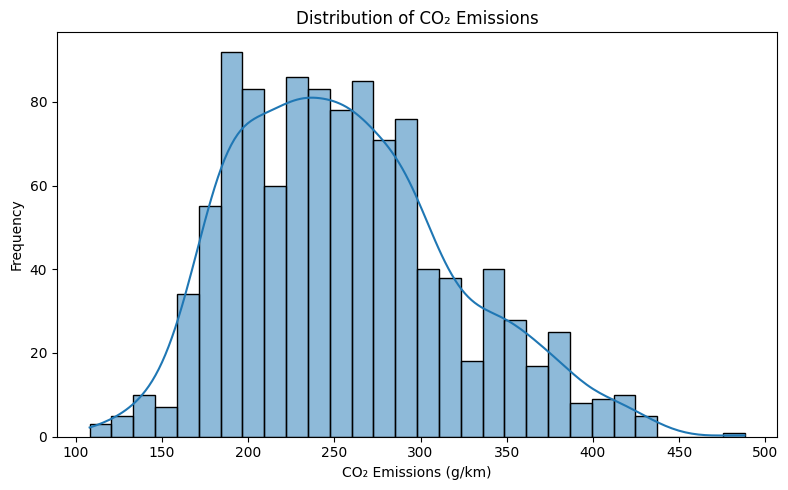

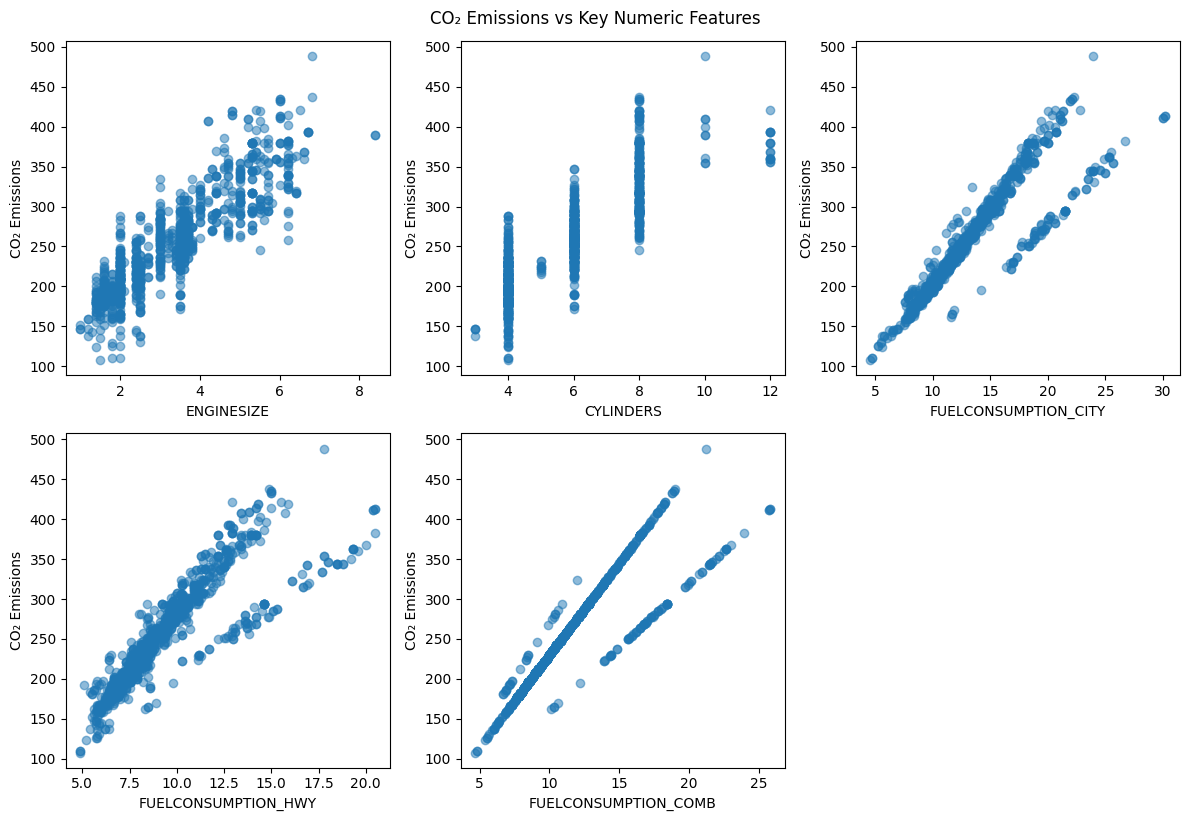

In [7]:
# --- 3. Basic EDA ---

# Keep only a subset of columns we care about
cols_of_interest = [
    "MODELYEAR", "MAKE", "MODEL", "VEHICLECLASS",
    "ENGINESIZE", "CYLINDERS",
    "FUELCONSUMPTION_CITY", "FUELCONSUMPTION_HWY", "FUELCONSUMPTION_COMB",
    "FUELTYPE", "CO2EMISSIONS"
]
df = df[cols_of_interest].copy()

print("Shape:", df.shape)
display(df.describe(include="all").transpose().head(15))

# Distribution of CO2 emissions
plt.figure(figsize=(8, 5))
sns.histplot(df["CO2EMISSIONS"], bins=30, kde=True)
plt.title("Distribution of CO₂ Emissions")
plt.xlabel("CO₂ Emissions (g/km)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Relationships between some numeric features and CO2EMISSIONS
numeric_features = ["ENGINESIZE", "CYLINDERS", "FUELCONSUMPTION_CITY",
                    "FUELCONSUMPTION_HWY", "FUELCONSUMPTION_COMB"]

plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_features, start=1):
    plt.subplot(2, 3, i)
    plt.scatter(df[col], df["CO2EMISSIONS"], alpha=0.5)
    plt.xlabel(col)
    plt.ylabel("CO₂ Emissions")
    plt.tight_layout()
plt.suptitle("CO₂ Emissions vs Key Numeric Features", y=1.02)
plt.show()


# **4. Correlation Heatmap**

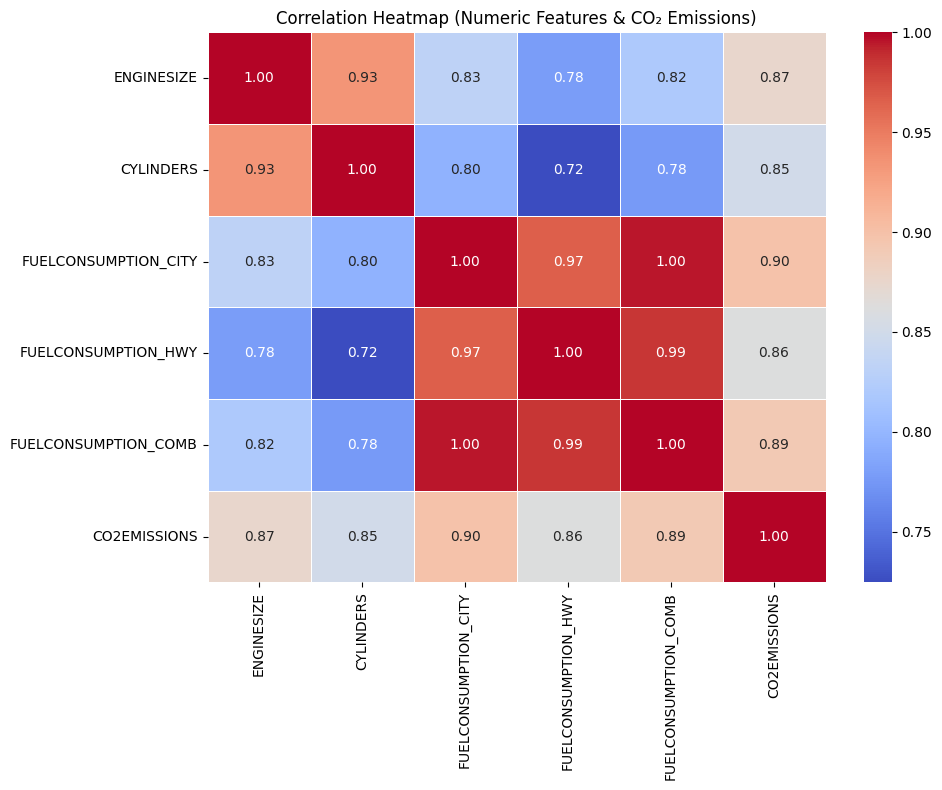

In [8]:
# --- 4. Correlation heatmap for numeric features ---

plt.figure(figsize=(10, 8))
corr = df[numeric_features + ["CO2EMISSIONS"]].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap (Numeric Features & CO₂ Emissions)")
plt.tight_layout()
plt.show()


# **5. 1D Setup: Engine Size vs CO₂**

Focusing on a Single Feature for Teaching SVR

To really *see* how Support Vector Regression behaves, it’s useful to start with a **simple 1D problem**:

> Predict CO₂ emissions using **only engine size** (`ENGINESIZE` → `CO2EMISSIONS`).

With a single feature we can:
- plot the model’s predicted curve easily,
- understand how different **kernels** and **hyperparameters** change the shape.




# **6. 1D Data Preparation**

X shape: (1067, 1)
y shape: (1067,)
Train size: 639
Val size: 214
Test size: 214


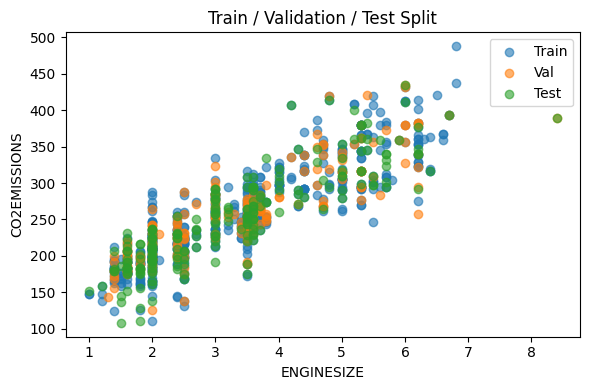

In [9]:
# --- 5. 1D data: ENGINESIZE -> CO2EMISSIONS ---

feature_col = "ENGINESIZE"
target_col = "CO2EMISSIONS"

X = df[[feature_col]].values  # shape (n_samples, 1)
y = df[target_col].values     # shape (n_samples,)

print("X shape:", X.shape)
print("y shape:", y.shape)

# Train / validation / test split: 60% / 20% / 20%
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=RANDOM_STATE
)  # 0.25 of 0.8 = 0.2

print("Train size:", X_train.shape[0])
print("Val size:", X_val.shape[0])
print("Test size:", X_test.shape[0])

# Scale the single feature for SVR and linear regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)
X_all_scaled   = scaler.transform(X)  # for plotting over full domain

# Visualise train / val / test split
plt.figure(figsize=(6, 4))
plt.scatter(X_train, y_train, alpha=0.6, label="Train")
plt.scatter(X_val, y_val, alpha=0.6, label="Val")
plt.scatter(X_test, y_test, alpha=0.6, label="Test")
plt.xlabel(feature_col)
plt.ylabel(target_col)
plt.title("Train / Validation / Test Split")
plt.legend()
plt.tight_layout()
plt.show()


# **7. Baseline: Linear Regression**



Before using SVR, we build a simple **linear regression** model on the 1D data.  
This gives us a baseline to compare against and shows what we gain by using more flexible models.


=== Linear Regression Baseline ===
Validation MSE: 921.0069754197591
Validation R² : 0.7444893170230016
Test MSE: 983.8034136585329
Test R² : 0.7620758449484815


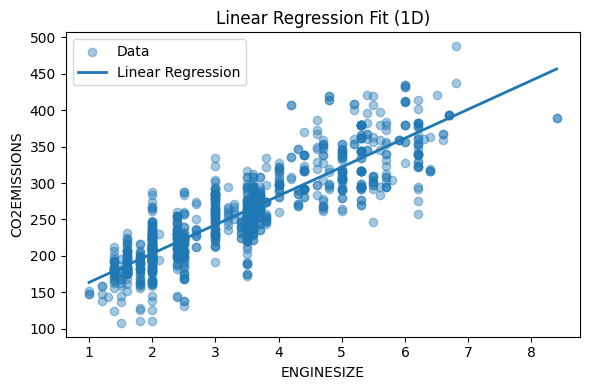

In [10]:
# --- 6. Linear Regression baseline (1D) ---

lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)

y_val_pred_lr  = lin_reg.predict(X_val_scaled)
y_test_pred_lr = lin_reg.predict(X_test_scaled)

print("=== Linear Regression Baseline ===")
print("Validation MSE:", mean_squared_error(y_val, y_val_pred_lr))
print("Validation R² :", r2_score(y_val, y_val_pred_lr))
print("Test MSE:", mean_squared_error(y_test, y_test_pred_lr))
print("Test R² :", r2_score(y_test, y_test_pred_lr))

# For 1D: sort X for smooth curve
sorted_idx = np.argsort(X.reshape(-1))
X_sorted = X[sorted_idx]
X_all_scaled_sorted = X_all_scaled[sorted_idx]

y_pred_lr_curve = lin_reg.predict(X_all_scaled_sorted)

plt.figure(figsize=(6, 4))
plt.scatter(X, y, alpha=0.4, label="Data")
plt.plot(X_sorted, y_pred_lr_curve, linewidth=2, label="Linear Regression")
plt.xlabel(feature_col)
plt.ylabel(target_col)
plt.title("Linear Regression Fit (1D)")
plt.legend()
plt.tight_layout()
plt.show()


# **8. SVR with Different Kernels**



Now we introduce **Support Vector Regression (SVR)**.  
SVR can use different **kernels** to model non-linear relationships:

- `linear` – basically a linear model with margin-based training.
- `poly` – polynomial features (quadratic, cubic, …).
- `rbf` – radial basis function, very flexible and widely used.

We’ll start with default parameters and then tune them.


Kernel = 'linear': Validation R² = 0.7433
Kernel = 'poly': Validation R² = -0.2450
Kernel = 'rbf': Validation R² = 0.7386


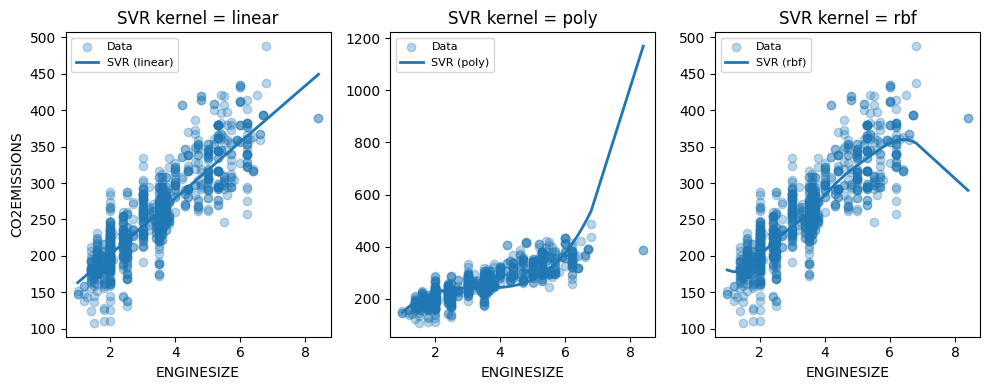

In [11]:
# --- 7. SVR with different kernels (1D) ---

kernels = ["linear", "poly", "rbf"]
svr_models = {}
val_scores = {}

for kernel in kernels:
    svr = SVR(kernel=kernel, C=10.0, epsilon=0.1, gamma="scale")
    svr.fit(X_train_scaled, y_train)
    svr_models[kernel] = svr

    y_val_pred = svr.predict(X_val_scaled)
    val_r2 = r2_score(y_val, y_val_pred)
    val_scores[kernel] = val_r2

    print(f"Kernel = {kernel!r}: Validation R² = {val_r2:.4f}")

# Plot fitted curves for each kernel
plt.figure(figsize=(10, 4))
for i, kernel in enumerate(kernels, start=1):
    plt.subplot(1, 3, i)
    svr = svr_models[kernel]
    y_pred_curve = svr.predict(X_all_scaled_sorted)
    plt.scatter(X, y, alpha=0.3, label="Data")
    plt.plot(X_sorted, y_pred_curve, linewidth=2, label=f"SVR ({kernel})")
    plt.xlabel(feature_col)
    if i == 1:
        plt.ylabel(target_col)
    plt.title(f"SVR kernel = {kernel}")
    plt.legend(fontsize=8)
    plt.tight_layout()
plt.show()


# **9. Hyperparameter Sweep: C**



The **C** parameter controls the trade-off between:
- Allowing training errors (larger margin, smoother model),
- Fitting the training data more closely (smaller margin).

Low C → smoother, higher bias.  
High C → can overfit, higher variance.

We’ll fix `kernel="rbf"` and `epsilon=0.1` and vary C.


C =    0.1   Train MSE = 2998.362   Val MSE = 2699.992
C =    1.0   Train MSE = 1303.181   Val MSE = 1236.028
C =   10.0   Train MSE =  953.869   Val MSE =  942.258
C =  100.0   Train MSE =  929.025   Val MSE =  921.190
C = 1000.0   Train MSE =  907.516   Val MSE =  912.766


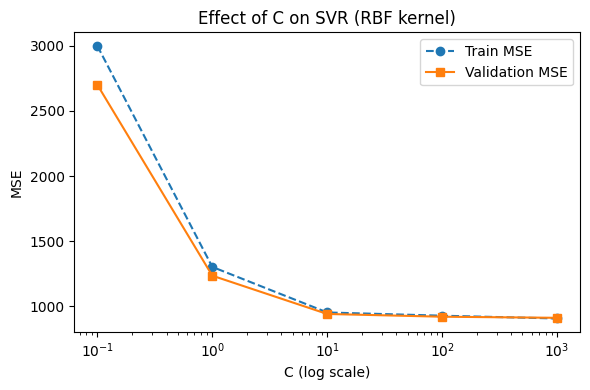

In [12]:
# --- 8. Hyperparameter sweep: C (RBF kernel) ---

C_values = [0.1, 1, 10, 100, 1000]
results_C = []

for C in C_values:
    svr_rbf = SVR(kernel="rbf", C=C, epsilon=0.1, gamma="scale")
    svr_rbf.fit(X_train_scaled, y_train)

    y_train_pred = svr_rbf.predict(X_train_scaled)
    y_val_pred   = svr_rbf.predict(X_val_scaled)

    train_mse = mean_squared_error(y_train, y_train_pred)
    val_mse   = mean_squared_error(y_val, y_val_pred)

    results_C.append((C, train_mse, val_mse))
    print(f"C = {C:6.1f}   Train MSE = {train_mse:8.3f}   Val MSE = {val_mse:8.3f}")

# Plot MSE vs C
train_mse_C = [r[1] for r in results_C]
val_mse_C   = [r[2] for r in results_C]

plt.figure(figsize=(6, 4))
plt.plot(C_values, train_mse_C, marker="o", linestyle="--", label="Train MSE")
plt.plot(C_values, val_mse_C, marker="s", linestyle="-", label="Validation MSE")
plt.xscale("log")
plt.xlabel("C (log scale)")
plt.ylabel("MSE")
plt.title("Effect of C on SVR (RBF kernel)")
plt.legend()
plt.tight_layout()
plt.show()


# **10. Hyperparameter Sweep: epsilon**



The **epsilon** parameter defines the width of the “ε-insensitive tube” around the regression function:

- Errors **inside** this tube are ignored (no loss).
- Only points **outside** the tube contribute to the loss.

Small epsilon → model tries to fit almost every data point → more complex.  
Large epsilon → model can ignore small deviations → smoother, simpler.



epsilon =  0.01   Train MSE =  954.489   Val MSE =  942.326
epsilon =  0.05   Train MSE =  954.208   Val MSE =  942.294
epsilon =  0.10   Train MSE =  953.869   Val MSE =  942.258
epsilon =  0.20   Train MSE =  953.300   Val MSE =  941.856
epsilon =  0.50   Train MSE =  953.704   Val MSE =  939.799


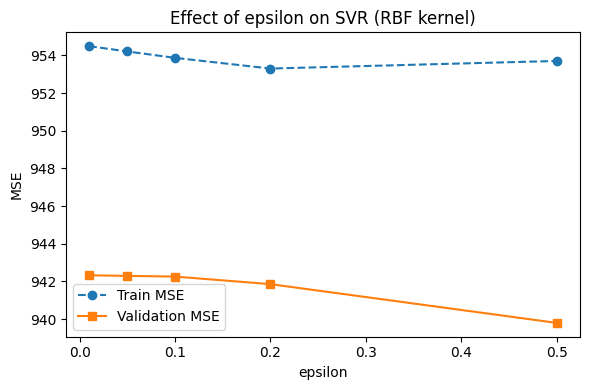

In [13]:
# --- 9. Hyperparameter sweep: epsilon (RBF kernel) ---

eps_values = [0.01, 0.05, 0.1, 0.2, 0.5]
results_eps = []

for eps in eps_values:
    svr_rbf = SVR(kernel="rbf", C=10.0, epsilon=eps, gamma="scale")
    svr_rbf.fit(X_train_scaled, y_train)

    y_train_pred = svr_rbf.predict(X_train_scaled)
    y_val_pred   = svr_rbf.predict(X_val_scaled)

    train_mse = mean_squared_error(y_train, y_train_pred)
    val_mse   = mean_squared_error(y_val, y_val_pred)
    results_eps.append((eps, train_mse, val_mse))
    print(f"epsilon = {eps:5.2f}   Train MSE = {train_mse:8.3f}   Val MSE = {val_mse:8.3f}")

# Plot MSE vs epsilon
train_mse_eps = [r[1] for r in results_eps]
val_mse_eps   = [r[2] for r in results_eps]

plt.figure(figsize=(6, 4))
plt.plot(eps_values, train_mse_eps, marker="o", linestyle="--", label="Train MSE")
plt.plot(eps_values, val_mse_eps, marker="s", linestyle="-", label="Validation MSE")
plt.xlabel("epsilon")
plt.ylabel("MSE")
plt.title("Effect of epsilon on SVR (RBF kernel)")
plt.legend()
plt.tight_layout()
plt.show()


# **11. Train Final SVR Model and Evaluate on Test Set**



Based on the validation experiments, we now pick a “good” configuration  
(e.g. `kernel="rbf"`, `C=10`, `epsilon=0.1`, `gamma="scale"`) and evaluate on the **test set**.

We also compare to the linear regression baseline and look at residuals.


=== Final SVR model (RBF, C=10, epsilon=0.1) ===
Test MSE: 986.558585537513
Test MAE: 24.20295110161756
Test R² : 0.7614095309956865

=== Linear Regression baseline (for comparison) ===
Test MSE: 983.8034136585329
Test MAE: 24.08523300199963
Test R² : 0.7620758449484815


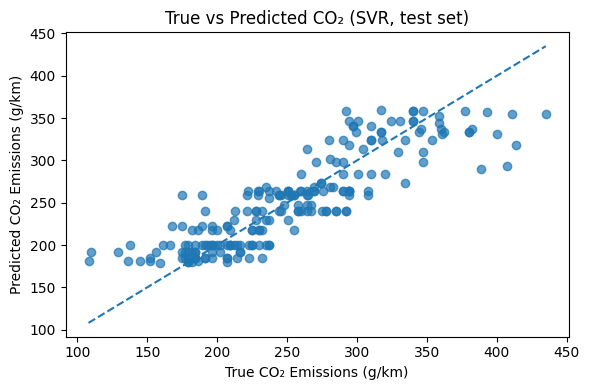

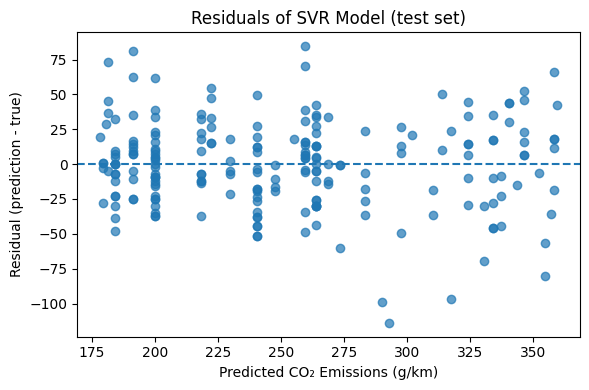

In [14]:
# --- 10. Final SVR model (1D) ---

best_svr = SVR(kernel="rbf", C=10.0, epsilon=0.1, gamma="scale")
best_svr.fit(X_train_scaled, y_train)

y_test_pred_best = best_svr.predict(X_test_scaled)

print("=== Final SVR model (RBF, C=10, epsilon=0.1) ===")
print("Test MSE:", mean_squared_error(y_test, y_test_pred_best))
print("Test MAE:", mean_absolute_error(y_test, y_test_pred_best))
print("Test R² :", r2_score(y_test, y_test_pred_best))

print("\n=== Linear Regression baseline (for comparison) ===")
print("Test MSE:", mean_squared_error(y_test, y_test_pred_lr))
print("Test MAE:", mean_absolute_error(y_test, y_test_pred_lr))
print("Test R² :", r2_score(y_test, y_test_pred_lr))

# True vs predicted (SVR)
plt.figure(figsize=(6, 4))
plt.scatter(y_test, y_test_pred_best, alpha=0.7)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle="--")
plt.xlabel("True CO₂ Emissions (g/km)")
plt.ylabel("Predicted CO₂ Emissions (g/km)")
plt.title("True vs Predicted CO₂ (SVR, test set)")
plt.tight_layout()
plt.show()

# Residual plot
residuals = y_test_pred_best - y_test
plt.figure(figsize=(6, 4))
plt.scatter(y_test_pred_best, residuals, alpha=0.7)
plt.axhline(0, linestyle="--")
plt.xlabel("Predicted CO₂ Emissions (g/km)")
plt.ylabel("Residual (prediction - true)")
plt.title("Residuals of SVR Model (test set)")
plt.tight_layout()
plt.show()


# **12. Multi-Feature SVR with ColumnTransformer**



So far we only used **engine size**. In reality, CO₂ emissions also depend on:

- Fuel consumption (city, highway, combined),
- Cylinders,
- Vehicle class, etc.

We now build a more realistic model using multiple features and a preprocessing **pipeline**:

- Numeric features → scaled with `StandardScaler`
- Categorical features → one-hot encoded (we’ll show the structure; feel free to enable/disable them depending on memory).


In [15]:
# --- 11. Multi-feature SVR pipeline ---

# Define numeric and categorical features
numeric_features_full = [
    "ENGINESIZE", "CYLINDERS",
    "FUELCONSUMPTION_CITY", "FUELCONSUMPTION_HWY", "FUELCONSUMPTION_COMB"
]
categorical_features_full = ["VEHICLECLASS", "FUELTYPE", "MAKE"]

# Drop rows with missing values in these columns
df_multi = df.dropna(subset=numeric_features_full + categorical_features_full + [target_col]).copy()

X_multi = df_multi[numeric_features_full + categorical_features_full]
y_multi = df_multi[target_col].values

X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(
    X_multi, y_multi, test_size=0.2, random_state=RANDOM_STATE
)

from sklearn.preprocessing import OneHotEncoder

# Preprocessing: scale numeric, one-hot encode categorical
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features_full),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features_full),
    ]
)

# Baseline linear regression pipeline
lin_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("regressor", LinearRegression())
    ]
)

# SVR pipeline with RBF kernel
svr_pipeline = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("regressor", SVR(kernel="rbf", C=10.0, epsilon=0.1, gamma="scale"))
    ]
)

# Fit and evaluate both models
lin_pipeline.fit(X_train_m, y_train_m)
svr_pipeline.fit(X_train_m, y_train_m)

y_pred_lin_m = lin_pipeline.predict(X_test_m)
y_pred_svr_m = svr_pipeline.predict(X_test_m)

print("=== Multi-feature Linear Regression ===")
print("Test R² :", r2_score(y_test_m, y_pred_lin_m))
print("Test MAE:", mean_absolute_error(y_test_m, y_pred_lin_m))
print("Test MSE:", mean_squared_error(y_test_m, y_pred_lin_m))

print("\n=== Multi-feature SVR (RBF) ===")
print("Test R² :", r2_score(y_test_m, y_pred_svr_m))
print("Test MAE:", mean_absolute_error(y_test_m, y_pred_svr_m))
print("Test MSE:", mean_squared_error(y_test_m, y_pred_svr_m))


=== Multi-feature Linear Regression ===
Test R² : 0.989296891484731
Test MAE: 3.578646255157669
Test MSE: 44.256770363644975

=== Multi-feature SVR (RBF) ===
Test R² : 0.970017341775231
Test MAE: 4.848977546918389
Test MSE: 123.97665762729198


# **13. Conclusion & Ethical Considerations**



In this tutorial we:

- Explored a real dataset of vehicle **fuel consumption** and **CO₂ emissions**.
- Built a **linear regression baseline** and several **SVR models**.
- Used a **1D example** (engine size → CO₂ emissions) to:
  - Compare different **kernels** (`linear`, `poly`, `rbf`),
  - Understand how **C** and **epsilon** affect SVR’s behaviour,
  - Visualise overfitting vs underfitting.
- Scaled up to a **multi-feature SVR pipeline** using `ColumnTransformer` and `Pipeline`.

**Why SVR?**

- With RBF kernel, SVR can capture complex, non-linear relationships between engine characteristics, fuel consumption and emissions.
- With careful tuning of **C** and **epsilon**, it can balance smoothness and accuracy.

**Ethical and societal impact**

Models like these could be used to:

- Estimate emissions for new vehicles,
- Help regulators design policies (e.g., emissions standards),
- Support manufacturers in optimising engine and fuel systems.

However, there are important caveats:

- **Data quality & bias** – If the dataset is unbalanced (e.g., over-representing one type of vehicle), predictions for underrepresented classes may be unreliable.
- **Transparency** – Kernel methods like SVR can be less interpretable than linear models, which matters when decisions affect taxes, regulations, or consumer choices.
- **Misuse** – Over-trusting model predictions without proper uncertainty analysis or validation can lead to unfair or unsafe decisions.

In practice, SVR should be one tool in a broader toolkit that includes:
- Interpretability methods (e.g., feature importance on simpler models),
- Careful evaluation across subgroups (vehicle classes, fuel types),
- Human oversight and domain expertise.

---

**Next steps you could explore:**

- Use cross-validation (`GridSearchCV` or `RandomizedSearchCV`) for more systematic hyperparameter tuning.
- Compare SVR with other models (Random Forests, Gradient Boosted Trees, Neural Networks).
- Analyse performance across **vehicle classes** or **fuel types** to check fairness and robustness.
